# Выбор локации для скважины

## Описание проекта

Проект заключается в разработке модели для определения локации новой скважины и максимизации прибыли для добывающей компании «ГлавРосГосНефть». Для этого необходимо провести сбор характеристик нефти и объема ее запасов в избранном регионе, затем построить модель для предсказания объема запасов в новых скважинах. Следующий шаг - выбор скважин с наивысшими оценками значений. Затем необходимо произвести анализ регионов с максимальной суммарной прибылью отобранных скважин. 

В рамках проекта предоставляются пробы нефти в трех регионах, характеристики каждой скважины известны. По этим данным необходимо построить модель для определения региона, где добыча нефти принесет наибольшую прибыль. В процессе анализа также используется техника Bootstrap для оценки возможных рисков и прибыли. 

Цель проекта - выбрать оптимальную локацию для бурения новой скважины, которая обеспечит наибольшую прибыль для компании.

## Описание данных

* `id` — уникальный идентификатор скважины
* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы)
* `product` — объём запасов в скважине (тыс. баррелей)

## Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

RANDOM_SEED = np.random.RandomState(23101996)

## Загрузка данных, подготовка и анализ

In [2]:
try:
    data1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
except:
    data1 = pd.read_csv('geo_data_0.csv')
    data2 = pd.read_csv('geo_data_1.csv')
    data3 = pd.read_csv('geo_data_2.csv')
    
datasets = (data1, data2, data3)

In [3]:
print(data1.info())
print(data1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.3437

In [4]:
print(data2.info())
print(data2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.7340

In [5]:
print(data3.info())
print(data3.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.8448

In [6]:
for i, k in enumerate(datasets):
    print(f'Дубликаты в данных №{i+1}: {k.duplicated().sum()}')

Дубликаты в данных №1: 0
Дубликаты в данных №2: 0
Дубликаты в данных №3: 0


В данных пропуски отсутствуют. Дубликатов также нет. Посмотрим как распределен целевой признак.

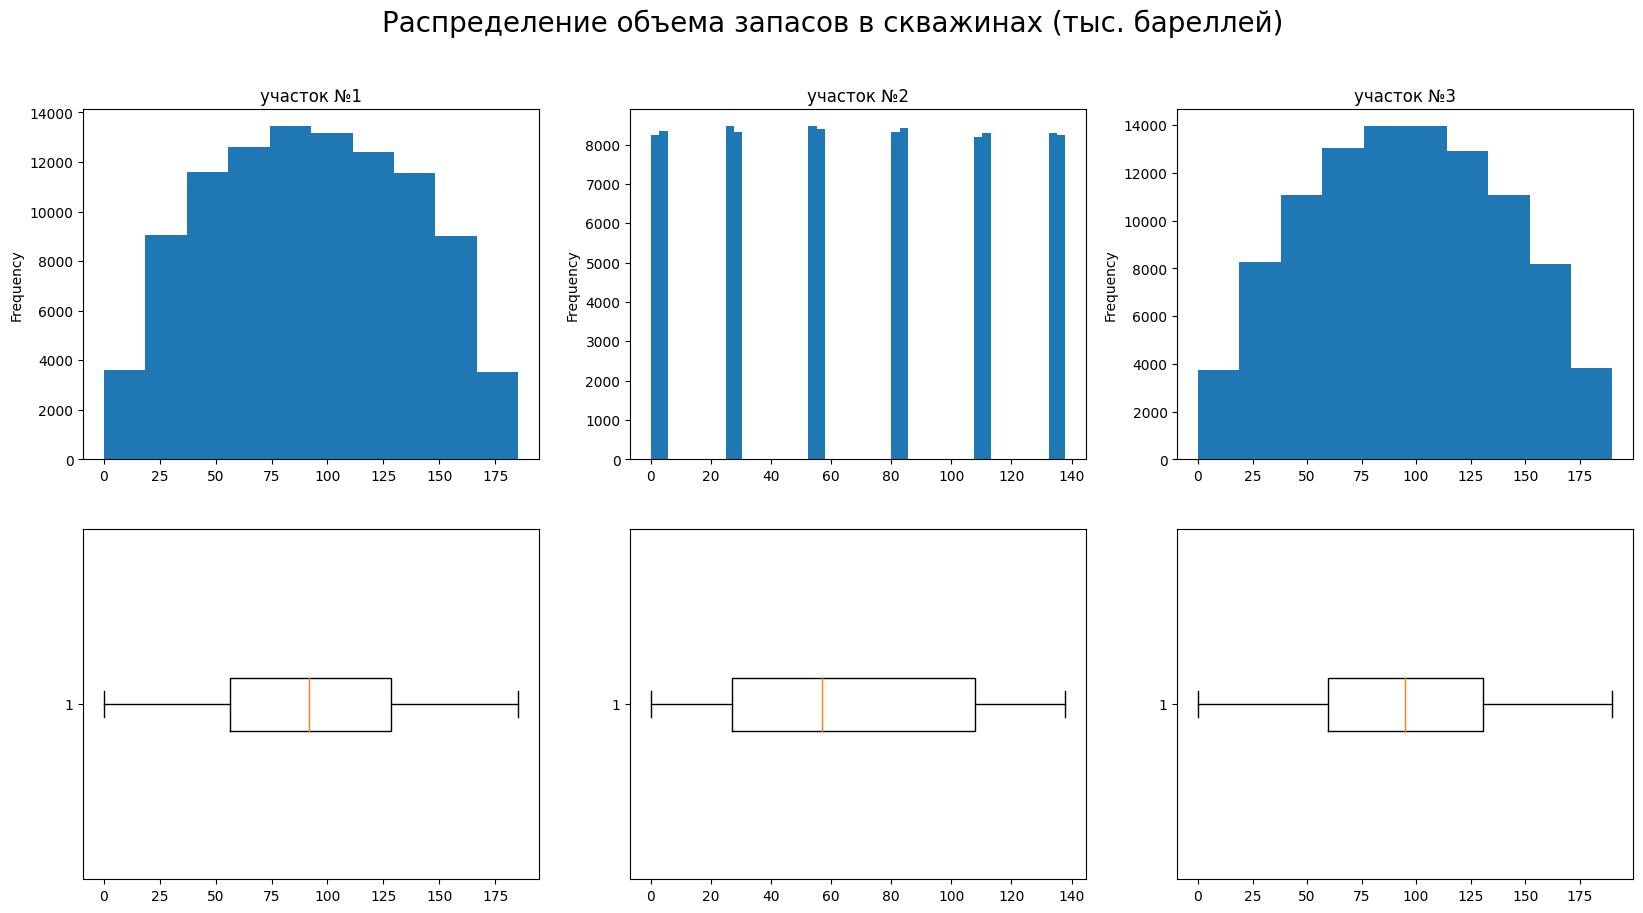

In [7]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

data1.plot(y='product', kind='hist', ax=axes[0,0], legend=None)
data2.plot(y='product', kind='hist', ax=axes[0,1], legend=None, bins=50)
data3.plot(y='product', kind='hist', ax=axes[0,2], legend=None)

axes[1,0].boxplot(data=data1, x='product', vert=False)
axes[1,1].boxplot(data=data2, x='product', vert=False)
axes[1,2].boxplot(data=data3, x='product', vert=False)

axes[0,0].set_title('участок №1')
axes[0,1].set_title('участок №2')
axes[0,2].set_title('участок №3')

fig.suptitle('Распределение объема запасов в скважинах (тыс. бареллей)', fontsize=20)

plt.show()

Наблюдаем, что на двух из трех участках распределение целевого признака похоже на нормальное, в то время как второй график показывает, что у нас есть 12 значений, которые приблизительно одинаково распределены.

Напишем функцию для обучения модели линейной регрессии.

## Обучение и проверка модели

In [8]:
def fit_linear_regression(data):
    # выделим признаки и целевую переменную
    X = data.drop(columns=['product', 'id'])
    y = data['product']
    
    # разобьем на обучающую и валидационную выборки
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
    # масштабируем данные для модели линейной регрессии
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    valid_X = pd.DataFrame(scaler.transform(valid_X), index=valid_X.index)
    
    # обучим модель
    model = LinearRegression()
    model.fit(train_X, train_y)
    predictions = pd.Series(data=model.predict(valid_X), index=valid_X.index)
    rmse = mean_squared_error(valid_y, predictions)**0.5
    
    print(f'RMSE: {rmse:.2f}')
    print(f'Средний запас сырья в скважине (предсказанный) в регионе: {np.mean(predictions):.2f}')
    
    return valid_y, predictions

In [9]:
target_valid_0, predictions_0 = fit_linear_regression(data1)

RMSE: 37.86
Средний запас сырья в скважине (предсказанный) в регионе: 92.55


In [10]:
target_valid_1, predictions_1 = fit_linear_regression(data2)

RMSE: 0.89
Средний запас сырья в скважине (предсказанный) в регионе: 68.99


In [11]:
target_valid_2, predictions_2 = fit_linear_regression(data3)

RMSE: 39.78
Средний запас сырья в скважине (предсказанный) в регионе: 95.29


В результате обучения моделей линейной регрессии и получения предсказаний на валидационных выборках для трех участков месторорождения можно сделать следующие выводы: наименьшее значение метрики rmse наблюдается на участке №2 (0.89). Количество получаемого продукта на участках 1 и 3 приблизительно одинаковое, в то время как на участке 2 оно в 1.35 раз меньше.

## Расчет прибыли

### Безубыточность новой скважины

In [12]:
# количество исследуемых точек при разведке
EXPLORED_POINTS = 500 

# количество лучших исследуемых точек 
BEST_EXPLORED_POINTS = 200 

# бюджет на разработку скважин в регионе
BUDGET = 10_000_000_000

# доход с 1000 баррелей продукта
PRODUCT_INCOME = 450_000

# максимальная вероятность убытков
MAX_LOSS = 0.025

# кол-во итераций
BOOTSTRAP = 1000

Расчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [13]:
min_value_of_total_product = BUDGET / PRODUCT_INCOME
print(f'Точка безубыточности: {min_value_of_total_product:.0f} тыс. баррелей')

min_value_of_product = min_value_of_total_product / BEST_EXPLORED_POINTS
print(f'Достаточный объём сырья для безубыточной разработки новой скважины равен: {min_value_of_product:.2f} тыс. баррелей')

Точка безубыточности: 22222 тыс. баррелей
Достаточный объём сырья для безубыточной разработки новой скважины равен: 111.11 тыс. баррелей


Если объем сырья на новой скважине будет равен 111.11 тыс. баррелей, то она будет безубыточной. Средний объем запаса скважин во всех трех регионах ниже, чем точка безубыточности, следовательно не все скважины являются окупаемыми.

### Расчёта прибыли по выбранным скважинам и предсказаниям модели

In [14]:
def calc_profit(target_values, prediction_values, show_info=False):
    
    # выберем скважины с максимальными значениями предсказаний
    best_explored_points = prediction_values.sort_values(ascending = False)[:BEST_EXPLORED_POINTS]
    
    # просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
    product_volume = target_values[best_explored_points.index].sum()
    
    # рассчитаем прибыль для полученного объёма сырья
    profit = PRODUCT_INCOME * product_volume - BUDGET
    
    if show_info:
        print(f'Прибыль (млн.руб): {profit/1_000_000}')
        print(f'Суммарный объем сырья (тыс.бареллей): {product_volume}')
    
    return profit, product_volume

In [15]:
print('Данные по участку №1:')
profit0, product_volume0 = calc_profit(target_valid_0, predictions_0, show_info=True)

Данные по участку №1:
Прибыль (млн.руб): 3363.6858917629415
Суммарный объем сырья (тыс.бареллей): 29697.079759473203


In [16]:
print('Данные по участку №2:')
profit1, product_volume1 = calc_profit(target_valid_1, predictions_1, show_info=True)

Данные по участку №2:
Прибыль (млн.руб): 2415.086696681511
Суммарный объем сырья (тыс.бареллей): 27589.081548181137


In [17]:
print('Данные по участку №3:')
profit2, product_volume2 = calc_profit(target_valid_2, predictions_2, show_info=True)

Данные по участку №3:
Прибыль (млн.руб): 2443.7204911003
Суммарный объем сырья (тыс.бареллей): 27652.71220244511


В результате расчета прибыли по 200 скважинам, которые дают наибольший объем сырья имеем следующие выводы:
1. Наибольший суммарный объем дают скважины на участке №1, следовательно и прыбиль там наибольшая
2. Участки №2 и №3 показывают приблизительно одинаковые значения прибыли и суммарного объема по 200 лучшим скважинам, которые были получены на основе машинного обучения в разделе 5

## Расчет рисков и прибылей для каждого региона

In [18]:
def calc_conf_interval_and_income(target_values, prediction_values):
    
    income_values = []
    
    for i in range(BOOTSTRAP):
        target_sample = target_values.sample(500, replace=True, random_state=RANDOM_SEED)
        predictions_sample = prediction_values[target_sample.index]
        income_values.append(calc_profit(target_sample, predictions_sample, show_info=False)[0])
        
    lower = round(np.percentile(income_values, 2.5), 0)/10**6
    higher = round(np.percentile(income_values, 97.5), 0)/10**6
    loss_probability = (pd.Series(income_values)<0).sum() / BOOTSTRAP
    mean_income = np.mean(income_values)/10**6
    
    print(f'Средняя прибыль (млн. руб): {mean_income:.2f}')
    print(f'95% доверительный интервал (млн. руб): {(lower, higher)}')
    print(f'Вероятность убытков равна {loss_probability}')
    
    return (mean_income, (lower, higher), loss_probability)

In [19]:
print('Данные по участку №1:')
mean_income0, conf_interval0, loss_probability0 = calc_conf_interval_and_income(target_valid_0, predictions_0)

Данные по участку №1:
Средняя прибыль (млн. руб): 598.14
95% доверительный интервал (млн. руб): (-36.559731, 1268.773798)
Вероятность убытков равна 0.033


In [20]:
print('Данные по участку №2:')
mean_income1, conf_interval1, loss_probability1 = calc_conf_interval_and_income(target_valid_1, predictions_1)

Данные по участку №2:
Средняя прибыль (млн. руб): 677.64
95% доверительный интервал (млн. руб): (150.229052, 1254.143916)
Вероятность убытков равна 0.005


In [21]:
print('Данные по участку №3:')
mean_income2, conf_interval2, loss_probability2 = calc_conf_interval_and_income(target_valid_2, predictions_2)

Данные по участку №3:
Средняя прибыль (млн. руб): 644.41
95% доверительный интервал (млн. руб): (59.981643, 1294.041259)
Вероятность убытков равна 0.014


## Общий вывод

1. Первоначально был выполнен анализ данных на предмет пропущенных значений, дубликатов, а также были изучены распределения целевого признака на всех 3 участках месторождения.

2. Затем были построены линейные модели для предсказания объемов сырья в скважинах. Далее была выполнена процедура бутстрэпа для определения 95% доверительного интервала среднего объема нефти в скважинах. 

3. На основании результатов бутстрэпа, регион №2 оказался наиболее перспективным для разработки, так как имеет наименьшие риски убытка, а средняя прибыль наивысшая.